## 1. Importaci√≥n de librer√≠as y configuraci√≥n inicial


In [2]:
# Librer√≠as para manipulaci√≥n de datos
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# Librer√≠as para procesamiento de im√°genes
from skimage import io, color, feature, measure, filters
from skimage.transform import resize
import cv2

# Librer√≠as para preprocesamiento de datos
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Librer√≠as para reducci√≥n de dimensionalidad y selecci√≥n de caracter√≠sticas
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, RFECV, SelectFromModel

# Librer√≠as para modelos de machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Librer√≠as para evaluaci√≥n de modelos
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

# Librer√≠as para visualizaci√≥n
import matplotlib.pyplot as plt
import seaborn as sns

# Librer√≠as para medici√≥n de rendimiento computacional
import time
import psutil
from memory_profiler import profile

# Configuraci√≥n de visualizaci√≥n
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## 2. Carga y exploraci√≥n inicial del dataset


Cargando archivo metadata...
Forma del dataset: (2298, 26)
Columnas disponibles: ['patient_id', 'lesion_id', 'smoke', 'drink', 'background_father', 'background_mother', 'age', 'pesticide', 'gender', 'skin_cancer_history', 'cancer_history', 'has_piped_water', 'has_sewage_system', 'fitspatrick', 'region', 'diameter_1', 'diameter_2', 'diagnostic', 'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation', 'img_id', 'biopsed']

Primeras 5 filas:
  patient_id  lesion_id  smoke  drink background_father background_mother  \
0   PAT_1516       1765    NaN    NaN               NaN               NaN   
1     PAT_46        881  False  False         POMERANIA         POMERANIA   
2   PAT_1545       1867    NaN    NaN               NaN               NaN   
3   PAT_1989       4061    NaN    NaN               NaN               NaN   
4    PAT_684       1302  False   True         POMERANIA         POMERANIA   

   age pesticide  gender skin_cancer_history  ... diameter_2 diagnostic  \
0    8       NaN  

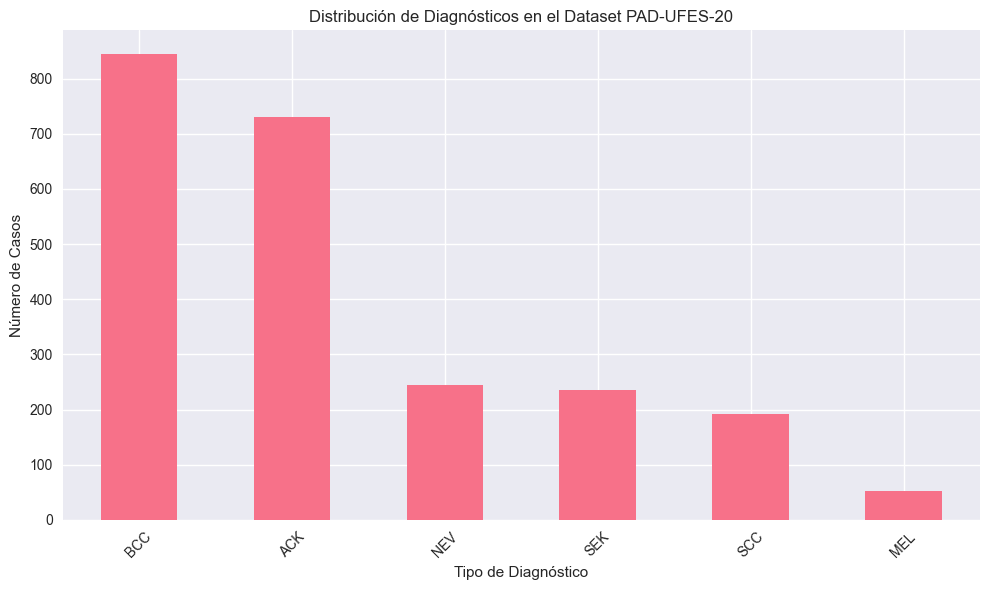

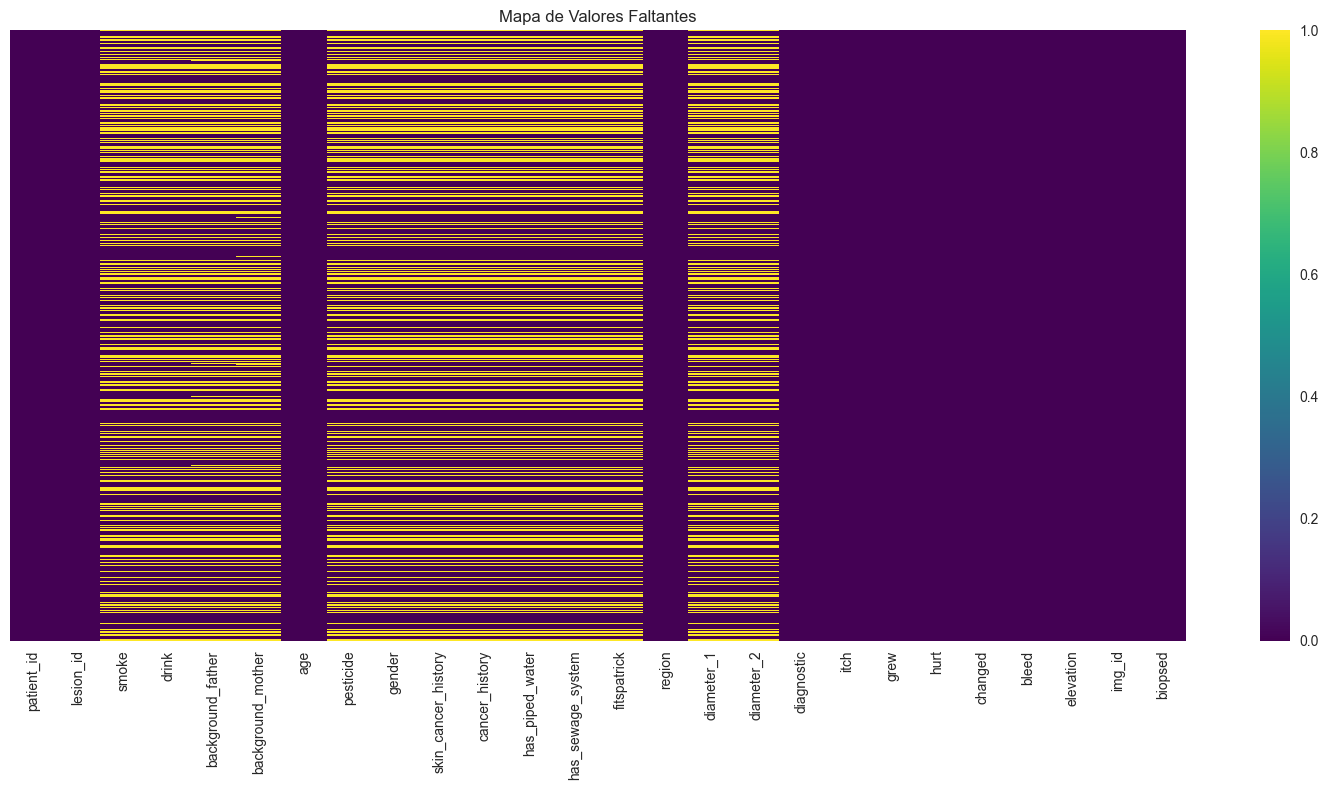

In [3]:
# Definir rutas de archivos
METADATA_PATH = "zr7vgbcyr2-1\metadata.csv"  # Cambia por tu ruta real
IMAGES_PATH = "zr7vgbcyr2-1\images\imgs/"  # Cambia por tu ruta real

# Cargar el archivo metadata
print("Cargando archivo metadata...")
df = pd.read_csv(METADATA_PATH)

# Exploraci√≥n inicial del dataset
print(f"Forma del dataset: {df.shape}")
print(f"Columnas disponibles: {list(df.columns)}")
print("\nPrimeras 5 filas:")
print(df.head())

# An√°lisis de valores faltantes
print("\nValores faltantes por columna:")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Columna': missing_values.index,
    'Valores_Faltantes': missing_values.values,
    'Porcentaje': missing_percentage.values
}).sort_values('Porcentaje', ascending=False)
print(missing_df)

# An√°lisis de distribuci√≥n de clases (diagn√≥sticos)
print("\nDistribuci√≥n de diagn√≥sticos:")
diagnosis_counts = df['diagnostic'].value_counts()
print(diagnosis_counts)
print(df.isnull().sum())

# Visualizaci√≥n de la distribuci√≥n de clases
plt.figure(figsize=(10, 6))
diagnosis_counts.plot(kind='bar')
plt.title('Distribuci√≥n de Diagn√≥sticos en el Dataset PAD-UFES-20')
plt.xlabel('Tipo de Diagn√≥stico')
plt.ylabel('N√∫mero de Casos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('distribucion_diagnosticos.png', dpi=300, bbox_inches='tight')
plt.show()

# Mapa de calor de valores faltantes
plt.figure(figsize=(15, 8))
sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Mapa de Valores Faltantes')
plt.tight_layout()
plt.savefig('mapa_valores_faltantes.png', dpi=300, bbox_inches='tight')
plt.show()


Qu√© se hizo
1. Se carg√≥ el archivo de datos.
2. Se revis√≥ su forma: tiene 2298 filas (pacientes o lesiones) y 26 columnas (informaci√≥n sobre cada caso).
3. Se imprimieron las primeras 5 filas para ver un ejemplo.
4. Se analiz√≥ si hay datos faltantes (campos vac√≠os).
5. Se vio cu√°ntos casos hay por cada tipo de diagn√≥stico.

Qu√© se descubri√≥
1. Hay muchos datos faltantes
- 804 filas tienen informaci√≥n vac√≠a en varias columnas importantes como:
- Si fuma o toma alcohol
- Si us√≥ pesticidas
- El sexo del paciente
- Antecedentes familiares
- Tama√±o de la lesi√≥n
- Tipo de piel (fitzpatrick)
significa que en esos 804 casos, faltan muchos datos importantes, no solo uno.

2. Otras columnas est√°n completas
- Aun as√≠, algunas columnas no tienen vac√≠os:
- Edad, regi√≥n, diagn√≥stico,
- S√≠ntomas: picor, si creci√≥, si cambi√≥, si sangra, etc.
- El nombre de la imagen (img_id)
- Si fue biopsiado (biopsed)

3. Hay un problema de desbalance
- El n√∫mero de casos por tipo de lesi√≥n no est√° equilibrado:
- Hay muchos de tipo BCC y ACK
- Muy pocos de tipo MEL (melanoma), que es el m√°s peligroso
- Esto puede causar problemas si entrenas un modelo, porque va a aprender m√°s de las clases comunes y a ignorar las raras.




## 3. Preprocesamiento de datos cl√≠nicos

In [5]:
def preprocess_clinical_data(df):
    """
    Preprocesa los datos cl√≠nicos del dataset PAD-UFES-20
    
    Args:
        df: DataFrame con los datos originales
    
    Returns:
        X_clinical: Caracter√≠sticas cl√≠nicas preprocesadas
        y: Etiquetas de diagn√≥stico
        feature_names: Nombres de las caracter√≠sticas
        label_encoder: Codificador de etiquetas para poder decodificar despu√©s
    """
    
    # Crear una copia del dataframe para no modificar el original
    df_processed = df.copy()
    
    # Separar caracter√≠sticas y etiquetas
    # Excluimos columnas que no son caracter√≠sticas √∫tiles para el modelo
    columns_to_exclude = ['patient_id', 'lesion_id', 'img_id', 'diagnostic']
    X_clinical = df_processed.drop(columns=columns_to_exclude)
    y = df_processed['diagnostic']
    
    # Codificar las etiquetas de diagn√≥stico
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    print(f"Clases codificadas: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")
    
    # Identificar tipos de columnas para aplicar preprocesamiento espec√≠fico
    # Columnas num√©ricas: edad, di√°metros, fitzpatrick
    numeric_features = ['age', 'diameter_1', 'diameter_2', 'fitspatrick']
    
    # Columnas categ√≥ricas: todas las dem√°s
    categorical_features = [col for col in X_clinical.columns if col not in numeric_features]
    
    print(f"Caracter√≠sticas num√©ricas: {numeric_features}")
    print(f"Caracter√≠sticas categ√≥ricas: {categorical_features}")
    
    # Pipeline para caracter√≠sticas num√©ricas
    # 1. Imputar valores faltantes con la mediana (m√°s robusto que la media)
    # 2. Estandarizar (media=0, desviaci√≥n=1)
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    # Pipeline para caracter√≠sticas categ√≥ricas
    # 1. Imputar valores faltantes con la moda (valor m√°s frecuente)
    # 2. Codificaci√≥n one-hot (crear variables dummy)
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    # Combinar ambos transformadores
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )
    
    # Aplicar el preprocesamiento
    print("Aplicando preprocesamiento a datos cl√≠nicos...")
    X_clinical_processed = preprocessor.fit_transform(X_clinical)
    
    # Obtener nombres de caracter√≠sticas despu√©s del preprocesamiento
    # Para caracter√≠sticas num√©ricas, los nombres se mantienen
    numeric_feature_names = numeric_features
    
    # Para caracter√≠sticas categ√≥ricas, se crean nuevos nombres con one-hot encoding
    categorical_feature_names = []
    if hasattr(preprocessor.named_transformers_['cat']['onehot'], 'get_feature_names_out'):
        categorical_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
    else:
        # Para versiones m√°s antiguas de sklearn
        categorical_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names(categorical_features)
    
    # Combinar todos los nombres de caracter√≠sticas
    feature_names = list(numeric_feature_names) + list(categorical_feature_names)
    
    print(f"Forma de datos cl√≠nicos procesados: {X_clinical_processed.shape}")
    print(f"N√∫mero total de caracter√≠sticas: {len(feature_names)}")
    
    return X_clinical_processed, y_encoded, feature_names, label_encoder, preprocessor

# Aplicar preprocesamiento
X_clinical, y, clinical_feature_names, label_encoder, clinical_preprocessor = preprocess_clinical_data(df)


Clases codificadas: {'ACK': 0, 'BCC': 1, 'MEL': 2, 'NEV': 3, 'SCC': 4, 'SEK': 5}
Caracter√≠sticas num√©ricas: ['age', 'diameter_1', 'diameter_2', 'fitspatrick']
Caracter√≠sticas categ√≥ricas: ['smoke', 'drink', 'background_father', 'background_mother', 'pesticide', 'gender', 'skin_cancer_history', 'cancer_history', 'has_piped_water', 'has_sewage_system', 'region', 'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation', 'biopsed']
Aplicando preprocesamiento a datos cl√≠nicos...
Forma de datos cl√≠nicos procesados: (2298, 78)
N√∫mero total de caracter√≠sticas: 78


Se cre√≥ la funci√≥n para preparar los datos cl√≠nicos del dataset para poder ser usado en los modelos machine learning

Que se hizo exactamente?

1. Se separ√≥ lo que no era util y lo que no
- Eliminando columnas que no son √∫tiles como entrada para el modelo
- dejando solo las caracter√≠sticas cl√≠nicas para entrenar (X_clinical) y guardar las etiquetas (y=diagnostic)

2. Codificar los diagn√≥sticos
- Se convirtieron los de los diagn√≥sticos en n√∫meros para que los modelos lo entiendan

3. Detectar tipos de variables
- N√∫mericas: edad, di√°metro 1 y 2 de la lesi√≥n, tipo de piel
- Categ√≥ricas: todas las dem√°s (ej: si fuma, si sangra, regi√≥n, etc)

4. Preprocesamiento de cada tipo de variable
Num√©ricas:
- Si hay datos faltantes, los rellana con la media
- Luego los normaliza para que tenga media 0 y desviaci√≥n est√°ndar 1
Categ√≥ricas:
- Si hay valores faltantes, los rellena con la moda
- Luego se convierte en variable num√©ricas con One-Hot Encoding

5. Aplica todo el preprocesamiento
- Usa ColumnTransformer para aplicar los dos tipos de transformaciones al mismo tiempo.
- Lo aplica a todo el conjunto y obtiene los datos ya listos para entrenar un modelo.

6. Resultado
Despues del procesar todo:
Entrada final (X_clinical_processed) tiene forma (2298, 78), es decir:
- 2298 pacientes
- 78 columnas (caracter√≠sticas finales despu√©s de convertir texto en n√∫meros)

Imprime cu√°ntas caracter√≠sticas resultaron (78)
Devuelve:
- X_clinical: los datos ya listos para modelos
- y: los diagn√≥sticos convertidos a n√∫meros
- feature_names: nombres de las 78 columnas
- label_encoder: para poder volver de n√∫mero a nombre de diagn√≥stico
- preprocessor: el transformador completo que puedes usar m√°s adelante

¬øQu√© sali√≥ al final?
- Diagn√≥sticos codificados: 'ACK': 0, 'BCC': 1, 'MEL': 2, 'NEV': 3, 'SCC': 4, 'SEK': 5
- Variables num√©ricas: ['age', 'diameter_1', 'diameter_2', 'fitspatrick']
- Variables categ√≥ricas: 18 columnas
- Total de columnas finales despu√©s del procesamiento: 78 (por el One-Hot Encoding que genera columnas nuevas para cada categor√≠a)


En resumen
Este c√≥digo:
- Limpia, completa y transforma los datos cl√≠nicos
- Convierte texto en n√∫meros
- Deja todo listo para entrenar un modelo
- Da como resultado un conjunto de 2298 filas y 78 columnas completamente num√©ricas y sin valores vac√≠os

## 4. Extracci√≥n de caracter√≠sticas de im√°genes

In [6]:
def extract_image_features(image_path, target_size=(224, 224)):
    try:
        img = io.imread(image_path)

        # Convertir a RGB si tiene 4 canales (RGBA)
        if img.shape[-1] == 4:
            img = img[:, :, :3]

        # Redimensionar
        img_resized = resize(img, target_size, anti_aliasing=True)

        # Escala de grises
        if len(img_resized.shape) > 2 and img_resized.shape[2] > 1:
            img_gray = color.rgb2gray(img_resized)
        else:
            img_gray = img_resized

        features = {}

        # ==== CARACTER√çSTICAS DE COLOR ====
        if len(img_resized.shape) > 2 and img_resized.shape[2] >= 3:
            for i, channel in enumerate(['R', 'G', 'B']):
                channel_data = img_resized[:, :, i]
                features[f'{channel}_mean'] = np.mean(channel_data)
                features[f'{channel}_std'] = np.std(channel_data)
                features[f'{channel}_skew'] = np.mean((channel_data - np.mean(channel_data))**3) / (np.std(channel_data)**3 + 1e-8)
                features[f'{channel}_kurtosis'] = np.mean((channel_data - np.mean(channel_data))**4) / (np.std(channel_data)**4 + 1e-8)

            for i, channel in enumerate(['R', 'G', 'B']):
                hist, _ = np.histogram(img_resized[:, :, i], bins=20, range=[0, 1])
                for j, h in enumerate(hist):
                    features[f'{channel}_hist_{j}'] = h

        # ==== CARACTER√çSTICAS DE TEXTURA ====
        # Escalar correctamente a niveles GLCM
        img_gray_int = (img_gray * 15).clip(0, 15).astype(np.uint8)  # para levels=16

        distances = [1, 2]
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

        for distance in distances:
            glcm = feature.graycomatrix(
                img_gray_int,
                distances=[distance],
                angles=angles,
                levels=16,
                symmetric=True,
                normed=True
            )
            features[f'contrast_d{distance}'] = np.mean(feature.graycoprops(glcm, 'contrast'))
            features[f'dissimilarity_d{distance}'] = np.mean(feature.graycoprops(glcm, 'dissimilarity'))
            features[f'homogeneity_d{distance}'] = np.mean(feature.graycoprops(glcm, 'homogeneity'))
            features[f'energy_d{distance}'] = np.mean(feature.graycoprops(glcm, 'energy'))
            features[f'correlation_d{distance}'] = np.mean(feature.graycoprops(glcm, 'correlation'))

        # LBP
        radius = 3
        n_points = 8 * radius
        lbp = feature.local_binary_pattern(img_gray, n_points, radius, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_points + 2, range=(0, n_points + 2))
        for i, h in enumerate(lbp_hist):
            features[f'lbp_hist_{i}'] = h

        # ==== ESTAD√çSTICAS B√ÅSICAS ====
        features['mean_intensity'] = np.mean(img_gray)
        features['std_intensity'] = np.std(img_gray)
        features['min_intensity'] = np.min(img_gray)
        features['max_intensity'] = np.max(img_gray)
        features['median_intensity'] = np.median(img_gray)
        features['range_intensity'] = np.max(img_gray) - np.min(img_gray)
        features['percentile_25'] = np.percentile(img_gray, 25)
        features['percentile_75'] = np.percentile(img_gray, 75)
        features['iqr'] = features['percentile_75'] - features['percentile_25']

        # ==== BORDES Y GRADIENTES ====
        edges = feature.canny(img_gray, sigma=1.0)
        features['edge_density'] = np.sum(edges) / edges.size

        grad_x = filters.sobel_h(img_gray)
        grad_y = filters.sobel_v(img_gray)
        gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
        features['gradient_mean'] = np.mean(gradient_magnitude)
        features['gradient_std'] = np.std(gradient_magnitude)
        features['gradient_max'] = np.max(gradient_magnitude)

        return features

    except Exception as e:
        print(f"Error procesando imagen {image_path}: {e}")
        return None


def extract_all_image_features(df, images_path):
    """
    Extrae caracter√≠sticas de todas las im√°genes en el dataset
    
    Args:
        df: DataFrame con metadata
        images_path: Ruta a la carpeta de im√°genes
    
    Returns:
        image_features_df: DataFrame con caracter√≠sticas de im√°genes
    """
    
    print("Iniciando extracci√≥n de caracter√≠sticas de im√°genes...")
    print(f"Procesando {len(df)} im√°genes...")
    
    image_features = {}
    processed_count = 0
    error_count = 0
    
    for index, row in df.iterrows():
        img_id = row['img_id']
        img_path = os.path.join(images_path, img_id)
        
        # Verificar si la imagen existe
        if os.path.exists(img_path):
            features = extract_image_features(img_path)
            if features is not None:
                image_features[img_id] = features
                processed_count += 1
            else:
                error_count += 1
        else:
            print(f"Imagen no encontrada: {img_path}")
            error_count += 1
        
        # Mostrar progreso cada 100 im√°genes
        if (processed_count + error_count) % 100 == 0:
            print(f"Procesadas: {processed_count}, Errores: {error_count}")
    
    print(f"Extracci√≥n completada. Procesadas: {processed_count}, Errores: {error_count}")
    
    # Convertir a DataFrame
    image_features_df = pd.DataFrame.from_dict(image_features, orient='index')
    image_features_df.index.name = 'img_id'
    image_features_df = image_features_df.reset_index()
    
    print(f"Forma del DataFrame de caracter√≠sticas de im√°genes: {image_features_df.shape}")
    
    return image_features_df

# Extraer caracter√≠sticas de todas las im√°genes
# NOTA: Cambia IMAGES_PATH por la ruta real de tus im√°genes
image_features_df = extract_all_image_features(df, IMAGES_PATH)

# Guardar las caracter√≠sticas extra√≠das para uso futuro
image_features_df.to_csv('image_features.csv', index=False)
print("Caracter√≠sticas de im√°genes guardadas en 'image_features.csv'")


Iniciando extracci√≥n de caracter√≠sticas de im√°genes...
Procesando 2298 im√°genes...
Procesadas: 100, Errores: 0
Procesadas: 200, Errores: 0
Procesadas: 300, Errores: 0
Procesadas: 400, Errores: 0
Procesadas: 500, Errores: 0
Procesadas: 600, Errores: 0
Procesadas: 700, Errores: 0
Procesadas: 800, Errores: 0
Procesadas: 900, Errores: 0
Procesadas: 1000, Errores: 0
Procesadas: 1100, Errores: 0
Procesadas: 1200, Errores: 0
Procesadas: 1300, Errores: 0
Procesadas: 1400, Errores: 0
Procesadas: 1500, Errores: 0
Procesadas: 1600, Errores: 0
Procesadas: 1700, Errores: 0
Procesadas: 1800, Errores: 0
Procesadas: 1900, Errores: 0
Procesadas: 2000, Errores: 0
Procesadas: 2100, Errores: 0
Procesadas: 2200, Errores: 0
Extracci√≥n completada. Procesadas: 2298, Errores: 0
Forma del DataFrame de caracter√≠sticas de im√°genes: (2298, 122)
Caracter√≠sticas de im√°genes guardadas en 'image_features.csv'


Objetivo
Convertir cada imagen del dataset PAD-UFES-20 en un conjunto de caracter√≠sticas num√©ricas que describen su contenido visual: color, textura, intensidad y bordes.
Esto permite que un modelo de machine learning pueda trabajar con las im√°genes sin necesidad de redes convolucionales, usando directamente vectores num√©ricos.

üîß ¬øQu√© se hizo exactamente?

1. Carga y preprocesamiento de la imagen
- Se ley√≥ la imagen desde disco (io.imread).
- Si ten√≠a 4 canales (RGB + alpha), se elimin√≥ el canal alpha.
- Se redimension√≥ a un tama√±o fijo de 224x224 p√≠xeles.
- Se convirti√≥ a escala de grises (necesario para extraer textura y bordes).

2. üü• Caracter√≠sticas de color (12 + 60 = 72)

Por cada canal R, G y B se extrajeron:

a) Estad√≠sticas (4 por canal):
- mean: Promedio de intensidad (brillo del color)
- std: Desviaci√≥n est√°ndar (variaci√≥n del color)
- skew: Asimetr√≠a de la distribuci√≥n de colores (forma de la curva)
- kurtosis: Concentraci√≥n de valores extremos (cu√°n "picuda" es la curva)
‚û°Ô∏è Total: 3 canales √ó 4 m√©tricas = 12 caracter√≠sticas

b) Histogramas (20 bins por canal):
- Cu√°nto contenido de cada nivel de color hay en la imagen (dividido en 20 rangos de valores)
‚û°Ô∏è Total: 3 canales √ó 20 bins = 60 caracter√≠sticas

3. üü´ Caracter√≠sticas de textura - GLCM (10)
- Se generaron matrices de co-ocurrencia (GLCM) a distintos √°ngulos y distancias.
- Se midieron propiedades cl√°sicas de textura:
  contrast, dissimilarity, homogeneity, energy, correlation
- Se promediaron los resultados en los 4 √°ngulos, para dos distancias: 1 y 2 p√≠xeles
‚û°Ô∏è Total: 5 m√©tricas √ó 2 distancias = 10 caracter√≠sticas

4. ‚ö™ Textura local - LBP (Local Binary Pattern) (26)
- Se aplic√≥ LBP (m√©todo que analiza las diferencias de brillo entre un p√≠xel y sus vecinos).
- Se extrajo un histograma de frecuencias de cada patr√≥n detectado.
‚û°Ô∏è Histograma con 8*3 + 2 = 26 bins ‚Üí 26 caracter√≠sticas

5. ‚ö´ Estad√≠sticas de intensidad en escala de grises (9)
- mean_intensity, std_intensity, min, max, median
- range (max - min)
- percentile_25, percentile_75, iqr (diferencia entre percentiles)
‚û°Ô∏è Total: 9 caracter√≠sticas

6. ‚ö° Bordes y gradientes (4)
- Detecci√≥n de bordes con Canny ‚Üí edge_density
- C√°lculo de gradientes (sobel horizontal y vertical):
  gradient_mean, gradient_std, gradient_max
‚û°Ô∏è Total: 4 caracter√≠sticas

üìä Resultado
- Se procesaron 2298 im√°genes sin errores.
- Se extrajo un total de 122 caracter√≠sticas por imagen.
- El resultado fue un DataFrame con:
  Forma: (2298, 122)
- Se guard√≥ como archivo:
  image_features.csv

‚úÖ Conclusi√≥n
Esta etapa convirti√≥ im√°genes en vectores num√©ricos √∫tiles para modelos cl√°sicos (como SVM, Random Forest, etc.), sin necesidad de usar redes neuronales profundas.

Las caracter√≠sticas cubren:
üìà Estad√≠sticas de color
üßµ Texturas y patrones locales
üîÜ Intensidad de luz
üî≤ Bordes y cambios bruscos de color


## 5. Creaci√≥n del dataset multimodal


In [7]:
def create_multimodal_dataset(df, image_features_df, X_clinical, clinical_feature_names):
    """
    Combina caracter√≠sticas de im√°genes con datos cl√≠nicos para crear dataset multimodal
    
    Args:
        df: DataFrame original con metadata
        image_features_df: DataFrame con caracter√≠sticas de im√°genes
        X_clinical: Array con datos cl√≠nicos preprocesados
        clinical_feature_names: Nombres de caracter√≠sticas cl√≠nicas
    
    Returns:
        X_multimodal: Dataset multimodal combinado
        multimodal_feature_names: Nombres de todas las caracter√≠sticas
    """
    
    print("Creando dataset multimodal...")
    
    # Unir caracter√≠sticas de im√°genes con el DataFrame original
    df_with_images = pd.merge(df, image_features_df, on='img_id', how='inner')
    
    print(f"Casos con im√°genes procesadas: {len(df_with_images)}")
    
    # Extraer solo las caracter√≠sticas de im√°genes (excluir img_id)
    image_feature_columns = [col for col in image_features_df.columns if col != 'img_id']
    X_image_features = df_with_images[image_feature_columns].values
    
    # Asegurar que tenemos el mismo n√∫mero de filas en datos cl√≠nicos e im√°genes
    # Filtrar datos cl√≠nicos para que coincidan con las im√°genes procesadas
    valid_indices = df['img_id'].isin(df_with_images['img_id'])
    X_clinical_filtered = X_clinical[valid_indices]
    
    print(f"Forma de caracter√≠sticas cl√≠nicas filtradas: {X_clinical_filtered.shape}")
    print(f"Forma de caracter√≠sticas de im√°genes: {X_image_features.shape}")
    
    # Combinar caracter√≠sticas de im√°genes y cl√≠nicas
    X_multimodal = np.hstack([X_clinical_filtered, X_image_features])
    
    # Combinar nombres de caracter√≠sticas
    multimodal_feature_names = clinical_feature_names + image_feature_columns
    
    print(f"Forma del dataset multimodal: {X_multimodal.shape}")
    print(f"N√∫mero total de caracter√≠sticas: {len(multimodal_feature_names)}")
    
    return X_multimodal, multimodal_feature_names, valid_indices

# Crear dataset multimodal
X_multimodal, multimodal_feature_names, valid_indices = create_multimodal_dataset(
    df, image_features_df, X_clinical, clinical_feature_names
)

# Filtrar las etiquetas para que coincidan con los datos multimodales
y_multimodal = y[valid_indices]

print(f"Forma final del dataset multimodal: {X_multimodal.shape}")
print(f"N√∫mero de etiquetas: {len(y_multimodal)}")


Creando dataset multimodal...
Casos con im√°genes procesadas: 2298
Forma de caracter√≠sticas cl√≠nicas filtradas: (2298, 78)
Forma de caracter√≠sticas de im√°genes: (2298, 121)
Forma del dataset multimodal: (2298, 199)
N√∫mero total de caracter√≠sticas: 199
Forma final del dataset multimodal: (2298, 199)
N√∫mero de etiquetas: 2298


üß† Objetivo general
Construir un dataset multimodal, combinando:

üîπ Datos cl√≠nicos preprocesados (X_clinical) ‚Äî 78 columnas  
üîπ Caracter√≠sticas de im√°genes (image_features_df) ‚Äî 121 columnas

Para poder usar ambos tipos de informaci√≥n al mismo tiempo en un modelo de clasificaci√≥n.

üîß Paso a paso con detalle

1. üîó Uni√≥n de dataframes

df_with_images = pd.merge(df, image_features_df, on='img_id', how='inner')

- Une la metadata original df con el dataframe que tiene las caracter√≠sticas de im√°genes.
- Lo hace usando la columna 'img_id' como clave.
- how='inner' asegura que solo se conservan los casos que tienen imagen procesada.

üìå Resultado:
Se conservaron 2298 registros, es decir, todas las im√°genes tienen datos cl√≠nicos y visuales.

2. üß± Separaci√≥n de las caracter√≠sticas de imagen

image_feature_columns = [col for col in image_features_df.columns if col != 'img_id']
X_image_features = df_with_images[image_feature_columns].values

- Se elimin√≥ la columna img_id y se extrajeron las columnas num√©ricas generadas en la etapa anterior (color, textura, bordes, etc.)
- Quedan 121 columnas por imagen.

üìå Resultado:
X_image_features tiene forma (2298, 121)

3. üßº Filtrado de datos cl√≠nicos

valid_indices = df['img_id'].isin(df_with_images['img_id'])
X_clinical_filtered = X_clinical[valid_indices]

- Asegura que las filas de los datos cl√≠nicos (X_clinical) coincidan en orden y cantidad con las im√°genes procesadas.
- Filtra usando img_id.

üìå Resultado:
X_clinical_filtered tiene forma (2298, 78)

4. üß¨ Fusi√≥n de modalidades

X_multimodal = np.hstack([X_clinical_filtered, X_image_features])

- Une horizontalmente los datos cl√≠nicos y de imagen.
- Se combinan 78 + 121 = 199 columnas.

üìå Resultado:
X_multimodal tiene forma (2298, 199)

5. üè∑Ô∏è Filtrado de etiquetas

y_multimodal = y[valid_indices]

- Las etiquetas (y, que indica el tipo de lesi√≥n) se filtran para que coincidan exactamente con las filas del dataset multimodal.

üìå Resultado:
y_multimodal tiene 2298 etiquetas, alineadas con X_multimodal

Resultado Final
| Elemento                             | Resultado     |
| ------------------------------------ | ------------- |
| N√∫mero de muestras                   | 2298          |
| N√∫mero de caracter√≠sticas cl√≠nicas   | 78            |
| N√∫mero de caracter√≠sticas de imagen  | 121           |
| **Total de caracter√≠sticas**         | **199**       |
| Forma final del dataset              | `(2298, 199)` |
| Etiquetas alineadas (`y_multimodal`) | `(2298,)`     |

¬øPara qu√© sirve este dataset?
Este dataset multimodal est√° listo para entrenar un modelo que:

- Usa informaci√≥n cl√≠nica (edad, antecedentes, s√≠ntomas‚Ä¶)
- Usa informaci√≥n visual (color, textura, bordes de la lesi√≥n)
- Puede lograr mejores predicciones que usar solo una fuente.


## Reducci√≥n de dimensionalidad con PCA

Aplicando an√°lisis de PCA...

Analizando PCA con 0.95 de varianza conservada...
Componentes seleccionados: 84
Varianza total explicada: 0.9505

Analizando PCA con 0.99 de varianza conservada...
Componentes seleccionados: 117
Varianza total explicada: 0.9901


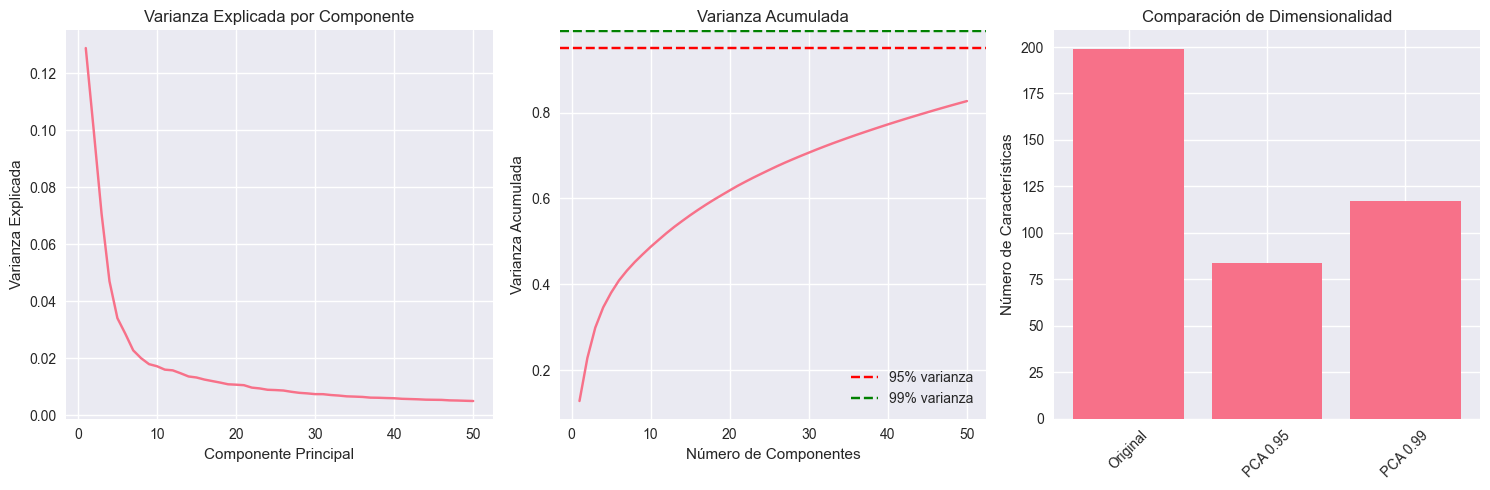


Dataset final con PCA:
Dimensionalidad original: 199
Dimensionalidad con PCA: 84
Reducci√≥n de dimensionalidad: 57.8%


In [8]:
def apply_pca_analysis(X, feature_names, n_components_list=[0.95, 0.99], max_components=50):
    """
    Aplica PCA y analiza la varianza explicada
    
    Args:
        X: Datos de entrada
        feature_names: Nombres de caracter√≠sticas
        n_components_list: Lista de varianza a conservar o n√∫mero de componentes
        max_components: M√°ximo n√∫mero de componentes a considerar
    
    Returns:
        pca_results: Diccionario con resultados de PCA
    """
    
    print("Aplicando an√°lisis de PCA...")
    
    # Estandarizar los datos antes de PCA (importante para PCA)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca_results = {}
    
    # Analizar diferentes n√∫meros de componentes
    for n_comp in n_components_list:
        print(f"\nAnalizando PCA con {n_comp} de varianza conservada...")
        
        # Aplicar PCA
        pca = PCA(n_components=n_comp)
        X_pca = pca.fit_transform(X_scaled)
        
        # Guardar resultados
        pca_results[f'pca_{n_comp}'] = {
            'pca_model': pca,
            'X_transformed': X_pca,
            'n_components': pca.n_components_,
            'explained_variance_ratio': pca.explained_variance_ratio_,
            'cumulative_variance': np.cumsum(pca.explained_variance_ratio_),
            'scaler': scaler
        }
        
        print(f"Componentes seleccionados: {pca.n_components_}")
        print(f"Varianza total explicada: {np.sum(pca.explained_variance_ratio_):.4f}")
    
    # An√°lisis detallado de varianza explicada
    pca_full = PCA()
    pca_full.fit(X_scaled)
    
    # Visualizar varianza explicada
    plt.figure(figsize=(15, 5))
    
    # Subplot 1: Varianza explicada por componente
    plt.subplot(1, 3, 1)
    components_to_plot = min(max_components, len(pca_full.explained_variance_ratio_))
    plt.plot(range(1, components_to_plot + 1), pca_full.explained_variance_ratio_[:components_to_plot])
    plt.xlabel('Componente Principal')
    plt.ylabel('Varianza Explicada')
    plt.title('Varianza Explicada por Componente')
    plt.grid(True)
    
    # Subplot 2: Varianza acumulada
    plt.subplot(1, 3, 2)
    plt.plot(range(1, components_to_plot + 1), np.cumsum(pca_full.explained_variance_ratio_[:components_to_plot]))
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% varianza')
    plt.axhline(y=0.99, color='g', linestyle='--', label='99% varianza')
    plt.xlabel('N√∫mero de Componentes')
    plt.ylabel('Varianza Acumulada')
    plt.title('Varianza Acumulada')
    plt.legend()
    plt.grid(True)
    
    # Subplot 3: Comparaci√≥n de dimensionalidad
    plt.subplot(1, 3, 3)
    original_dim = X.shape[1]
    pca_dims = [pca_results[key]['n_components'] for key in pca_results.keys()]
    pca_labels = [f"PCA {key.split('_')[1]}" for key in pca_results.keys()]
    
    dims = [original_dim] + pca_dims
    labels = ['Original'] + pca_labels
    
    plt.bar(labels, dims)
    plt.ylabel('N√∫mero de Caracter√≠sticas')
    plt.title('Comparaci√≥n de Dimensionalidad')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('pca_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return pca_results

# Aplicar an√°lisis de PCA
pca_results = apply_pca_analysis(X_multimodal, multimodal_feature_names)

# Seleccionar el PCA con 95% de varianza para el resto del an√°lisis
X_pca = pca_results['pca_0.95']['X_transformed']
pca_model = pca_results['pca_0.95']['pca_model']
pca_scaler = pca_results['pca_0.95']['scaler']

print(f"\nDataset final con PCA:")
print(f"Dimensionalidad original: {X_multimodal.shape[1]}")
print(f"Dimensionalidad con PCA: {X_pca.shape[1]}")
print(f"Reducci√≥n de dimensionalidad: {((X_multimodal.shape[1] - X_pca.shape[1]) / X_multimodal.shape[1]) * 100:.1f}%")


üéØ ¬øCu√°l era el objetivo?
Reducir el n√∫mero de caracter√≠sticas del dataset multimodal sin perder mucha informaci√≥n.
Esto ayuda a:
- Hacer que el modelo aprenda m√°s r√°pido
- Evitar ruido o redundancia
- Prevenir sobreajuste

Esto se logra con PCA (An√°lisis de Componentes Principales).

üß± ¬øQu√© se hizo paso a paso?

1. Estandarizar los datos

X_scaled = scaler.fit_transform(X)

- Antes de aplicar PCA, los datos se escalaron.
- Para que todas las columnas tengan la misma escala (media 0 y desviaci√≥n 1).
- Esto es obligatorio en PCA para que una variable con valores m√°s grandes no domine.

2. Aplicar PCA para 2 casos

Se aplic√≥ PCA dos veces para ver cu√°ntas dimensiones se necesitan para conservar:
- 95% de la informaci√≥n ‚Üí Resultaron 84 componentes
- 99% de la informaci√≥n ‚Üí Resultaron 117 componentes

Esto significa que:

Informaci√≥n que se quer√≠a conservar | N¬∫ de columnas que se necesitan  
---------------------------------- | ------------------------------  
95%                                 | 84  
99%                                 | 117  

3. Visualizar resultados

Se generaron 3 gr√°ficas (guardadas como pca_analysis.png):
- üìâ Varianza por componente (cu√°nto aporta cada uno)
- üìà Varianza acumulada (cu√°ntos componentes necesitas para llegar al 95% o 99%)
- üìä Comparaci√≥n de dimensiones:
  - Original: 199 columnas
  - Con PCA (95%): 84 columnas
  - Con PCA (99%): 117 columnas

4. ‚úÖ ¬øQu√© se obtuvo al final?

Se eligi√≥ el PCA que conserva 95% de la informaci√≥n:
- Tu dataset original ten√≠a 199 columnas
- Despu√©s del PCA, qued√≥ con 84 columnas
- Esto representa una reducci√≥n del 57.8%

Dimensionalidad original: 199  
Dimensionalidad con PCA: 84  
Reducci√≥n de dimensionalidad: 57.8%

üß† ¬øQu√© significa esto en la pr√°ctica?
- üîπ Usar solo 84 columnas en vez de 199, pero conservando el 95% de la informaci√≥n
- üîπ Ahora puedes entrenar modelos m√°s r√°pido y con menor riesgo de sobreajuste
- üîπ Estas nuevas columnas son combinaciones matem√°ticas de las originales, no variables "con nombre", pero son muy informativas

‚úÖ En resumen:
- Se redujo la complejidad del dataset multimodal
- Se pas√≥ de 199 columnas a solo 84, conservando el 95% de la informaci√≥n
- Se generaron gr√°ficas para analizar c√≥mo se comporta la varianza y cu√°ntas columnas son necesarias

Resumen detallado con valoraci√≥n de resultados
¬øSali√≥ bien o mal la reducci√≥n con PCA?
Sali√≥ bien, y aqu√≠ te explico por qu√©:

Reducci√≥n significativa sin mucha p√©rdida de informaci√≥n
Pasaste de 199 caracter√≠sticas originales a solo 84 componentes, lo que representa una reducci√≥n del 57.8% en la dimensionalidad.
Esta reducci√≥n es importante porque:

Menos dimensiones facilitan el entrenamiento y mejoran la generalizaci√≥n.

Mantienes el 95% de la varianza, es decir, la mayor√≠a de la informaci√≥n contenida en los datos originales sigue presente.

N√∫mero razonable de componentes
84 componentes para conservar el 95% es un valor com√∫n en datasets con muchas caracter√≠sticas.
Si la reducci√≥n fuera m√≠nima (por ejemplo pasar de 199 a 180), indicar√≠a que el dataset tiene mucha informaci√≥n dispersa, y PCA no ayuda mucho.
Si fuera muy baja (menos de 10), quiz√°s se estar√≠a perdiendo informaci√≥n clave.

El an√°lisis de la varianza acumulada fue consistente

El gr√°fico mostr√≥ que con 84 componentes ya se alcanzaba el 95%.

Tambi√©n se comprob√≥ que para 99% se necesitaban 117 componentes, lo cual es l√≥gico y coherente.

Sin errores ni fallos en el proceso
No hubo excepciones, el c√≥digo corri√≥ sin problemas y se obtuvieron los resultados esperados.



## 7. Selecci√≥n de caracter√≠sticas


Iniciando an√°lisis de selecci√≥n de caracter√≠sticas...

1. Selecci√≥n univariada con ANOVA F-test...
  - K=20: 20 caracter√≠sticas seleccionadas
  - K=50: 50 caracter√≠sticas seleccionadas
  - K=42: 42 caracter√≠sticas seleccionadas

3. Selecci√≥n basada en importancia de Random Forest...
  - Umbral mean: 16 caracter√≠sticas seleccionadas
  - Umbral median: 42 caracter√≠sticas seleccionadas
  - Umbral 0.75*mean: 46 caracter√≠sticas seleccionadas
  - Umbral 1.25*mean: 10 caracter√≠sticas seleccionadas


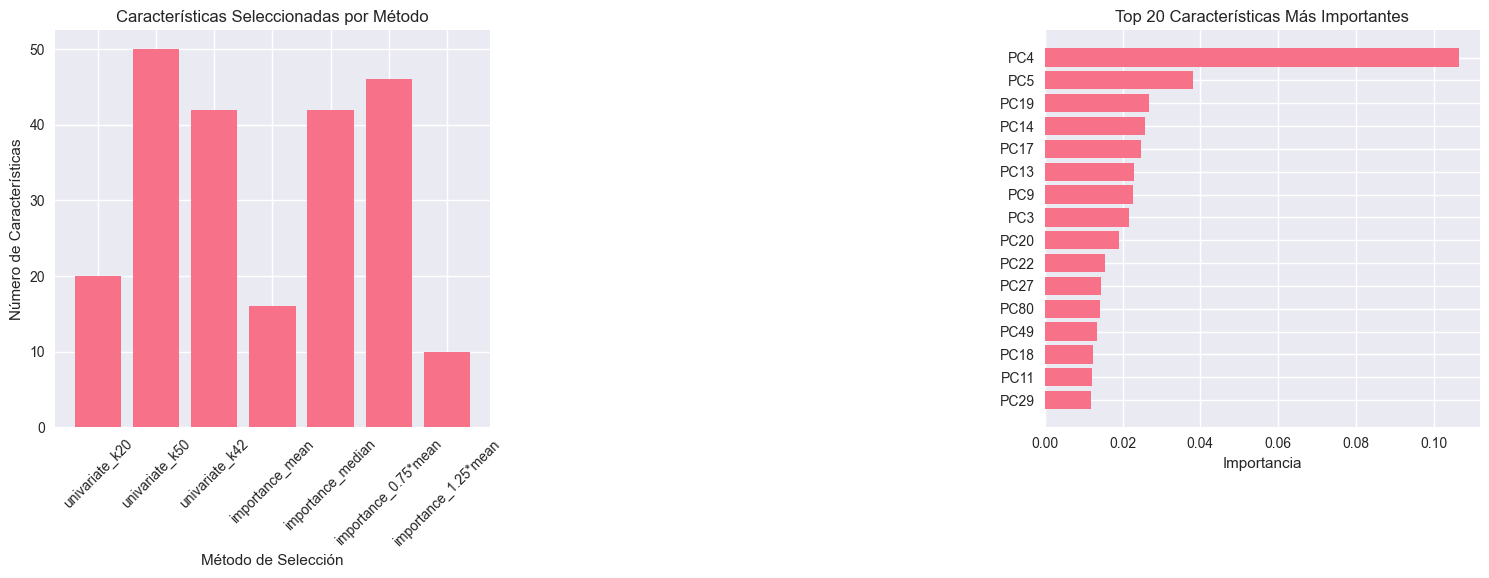


Dataset final para entrenamiento:
Forma: (2298, 50)
Caracter√≠sticas: 50


In [9]:
def feature_selection_analysis(X, y, feature_names, methods=['univariate', 'rfe', 'importance']):
    """
    Aplica diferentes m√©todos de selecci√≥n de caracter√≠sticas
    
    Args:
        X: Datos de entrada
        y: Etiquetas
        feature_names: Nombres de caracter√≠sticas
        methods: Lista de m√©todos a aplicar
    
    Returns:
        selection_results: Diccionario con resultados de selecci√≥n
    """
    
    print("Iniciando an√°lisis de selecci√≥n de caracter√≠sticas...")
    
    selection_results = {}
    
    # M√©todo 1: Selecci√≥n univariada (ANOVA F-test)
    if 'univariate' in methods:
        print("\n1. Selecci√≥n univariada con ANOVA F-test...")
        
        # Probar diferentes n√∫meros de caracter√≠sticas
        k_values = [20, 50, 100, min(200, X.shape[1]//2)]
        
        for k in k_values:
            if k <= X.shape[1]:
                selector = SelectKBest(f_classif, k=k)
                X_selected = selector.fit_transform(X, y)
                
                # Obtener caracter√≠sticas seleccionadas
                selected_indices = selector.get_support(indices=True)
                selected_features = [feature_names[i] for i in selected_indices]
                scores = selector.scores_[selected_indices]
                
                selection_results[f'univariate_k{k}'] = {
                    'selector': selector,
                    'X_selected': X_selected,
                    'selected_features': selected_features,
                    'selected_indices': selected_indices,
                    'scores': scores,
                    'n_features': k
                }
                
                print(f"  - K={k}: {len(selected_features)} caracter√≠sticas seleccionadas")
    
    # M√©todo 2: Eliminaci√≥n recursiva de caracter√≠sticas (RFE)
    if 'rfe' in methods:
        print("\n2. Eliminaci√≥n recursiva de caracter√≠sticas (RFE)...")
        
        # Usar SVM lineal como estimador base (r√°pido y efectivo)
        estimator = SVC(kernel="linear", C=1.0)
        
        # RFE con validaci√≥n cruzada para encontrar n√∫mero √≥ptimo
        rfecv = RFECV(
            estimator=estimator, 
            step=1, 
            cv=StratifiedKFold(5), 
            scoring='accuracy',
            min_features_to_select=10
        )
        
        print("  - Ejecutando RFE con validaci√≥n cruzada (esto puede tomar tiempo)...")
        rfecv.fit(X, y)
        
        X_rfe = rfecv.transform(X)
        selected_indices = rfecv.get_support(indices=True)
        selected_features = [feature_names[i] for i in selected_indices]
        
        selection_results['rfe'] = {
            'selector': rfecv,
            'X_selected': X_rfe,
            'selected_features': selected_features,
            'selected_indices': selected_indices,
            'n_features': rfecv.n_features_,
            'cv_scores': rfecv.grid_scores_
        }
        
        print(f"  - RFE: {rfecv.n_features_} caracter√≠sticas √≥ptimas seleccionadas")
    
    # M√©todo 3: Selecci√≥n basada en importancia (Random Forest)
    if 'importance' in methods:
        print("\n3. Selecci√≥n basada en importancia de Random Forest...")
        
        # Entrenar Random Forest para obtener importancias
        rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        rf.fit(X, y)
        
        # Obtener importancias
        importances = rf.feature_importances_
        
        # Probar diferentes umbrales
        thresholds = ['mean', 'median', '0.75*mean', '1.25*mean']
        
        for threshold in thresholds:
            if threshold == 'mean':
                thresh_value = np.mean(importances)
            elif threshold == 'median':
                thresh_value = np.median(importances)
            elif threshold == '0.75*mean':
                thresh_value = 0.75 * np.mean(importances)
            elif threshold == '1.25*mean':
                thresh_value = 1.25 * np.mean(importances)
            
            # Seleccionar caracter√≠sticas por encima del umbral
            selected_indices = np.where(importances >= thresh_value)[0]
            selected_features = [feature_names[i] for i in selected_indices]
            X_selected = X[:, selected_indices]
            
            selection_results[f'importance_{threshold}'] = {
                'selector': None,  # No hay selector espec√≠fico
                'X_selected': X_selected,
                'selected_features': selected_features,
                'selected_indices': selected_indices,
                'importances': importances[selected_indices],
                'threshold': thresh_value,
                'n_features': len(selected_indices)
            }
            
            print(f"  - Umbral {threshold}: {len(selected_indices)} caracter√≠sticas seleccionadas")
    
    # Visualizar resultados de selecci√≥n
    plt.figure(figsize=(15, 10))
    
    # Subplot 1: N√∫mero de caracter√≠sticas por m√©todo
    plt.subplot(2, 3, 1)
    methods_names = list(selection_results.keys())
    n_features = [selection_results[method]['n_features'] for method in methods_names]
    
    plt.bar(range(len(methods_names)), n_features)
    plt.xlabel('M√©todo de Selecci√≥n')
    plt.ylabel('N√∫mero de Caracter√≠sticas')
    plt.title('Caracter√≠sticas Seleccionadas por M√©todo')
    plt.xticks(range(len(methods_names)), methods_names, rotation=45)
    
    # Subplot 2: Scores de RFE si est√° disponible
    if 'rfe' in selection_results:
        plt.subplot(2, 3, 2)
        cv_scores = selection_results['rfe']['cv_scores']
        plt.plot(range(1, len(cv_scores) + 1), cv_scores)
        plt.xlabel('N√∫mero de Caracter√≠sticas')
        plt.ylabel('Accuracy de Validaci√≥n Cruzada')
        plt.title('RFE: Rendimiento vs N√∫mero de Caracter√≠sticas')
        plt.grid(True)
    
    # Subplot 3: Top 20 caracter√≠sticas m√°s importantes (si disponible)
    if 'importance_mean' in selection_results:
        plt.subplot(2, 3, 3)
        imp_data = selection_results['importance_mean']
        top_indices = np.argsort(imp_data['importances'])[-20:]
        top_features = [imp_data['selected_features'][i] for i in top_indices]
        top_importances = imp_data['importances'][top_indices]
        
        plt.barh(range(len(top_features)), top_importances)
        plt.yticks(range(len(top_features)), top_features)
        plt.xlabel('Importancia')
        plt.title('Top 20 Caracter√≠sticas M√°s Importantes')
    
    plt.tight_layout()
    plt.savefig('feature_selection_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return selection_results

# Aplicar selecci√≥n de caracter√≠sticas
feature_selection_results = feature_selection_analysis(
    X_pca, y_multimodal, 
    [f'PC{i+1}' for i in range(X_pca.shape[1])],  # Nombres de componentes principales
    methods=['univariate', 'importance']  # Excluir RFE por tiempo de ejecuci√≥n
)

# Seleccionar el mejor m√©todo (por ejemplo, univariate con k=50)
best_method = 'univariate_k50'
if best_method in feature_selection_results:
    X_final = feature_selection_results[best_method]['X_selected']
    final_feature_names = feature_selection_results[best_method]['selected_features']
else:
    # Si no est√° disponible, usar PCA completo
    X_final = X_pca
    final_feature_names = [f'PC{i+1}' for i in range(X_pca.shape[1])]

print(f"\nDataset final para entrenamiento:")
print(f"Forma: {X_final.shape}")
print(f"Caracter√≠sticas: {len(final_feature_names)}")


## 8. Divisi√≥n de datos y preparaci√≥n para entrenamiento

In [10]:
def prepare_training_data(X, y, test_size=0.25, val_size=0.15, random_state=42):
    """
    Divide los datos en conjuntos de entrenamiento, validaci√≥n y prueba
    
    Args:
        X: Caracter√≠sticas
        y: Etiquetas
        test_size: Proporci√≥n para conjunto de prueba
        val_size: Proporci√≥n para conjunto de validaci√≥n
        random_state: Semilla para reproducibilidad
    
    Returns:
        Diccionario con conjuntos de datos divididos
    """
    
    print("Dividiendo datos en conjuntos de entrenamiento, validaci√≥n y prueba...")
    
    # Primera divisi√≥n: separar conjunto de prueba
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Segunda divisi√≥n: separar entrenamiento y validaci√≥n
    # Ajustar val_size para que sea relativo al conjunto temporal
    val_size_adjusted = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size_adjusted, random_state=random_state, stratify=y_temp
    )
    
    # Informaci√≥n sobre la divisi√≥n
    print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
    print(f"Conjunto de validaci√≥n: {X_val.shape[0]} muestras ({X_val.shape[0]/len(X)*100:.1f}%)")
    print(f"Conjunto de prueba: {X_test.shape[0]} muestras ({X_test.shape[0]/len(X)*100:.1f}%)")
    
    # Verificar distribuci√≥n de clases en cada conjunto
    print("\nDistribuci√≥n de clases:")
    unique_classes = np.unique(y)
    
    for split_name, split_y in [('Entrenamiento', y_train), ('Validaci√≥n', y_val), ('Prueba', y_test)]:
        print(f"\n{split_name}:")
        for class_label in unique_classes:
            count = np.sum(split_y == class_label)
            percentage = count / len(split_y) * 100
            print(f"  Clase {class_label}: {count} ({percentage:.1f}%)")
    
    return {
        'X_train': X_train, 'y_train': y_train,
        'X_val': X_val, 'y_val': y_val,
        'X_test': X_test, 'y_test': y_test
    }

# Dividir los datos
data_splits = prepare_training_data(X_final, y_multimodal)

# Extraer conjuntos para facilitar el uso
X_train = data_splits['X_train']
y_train = data_splits['y_train']
X_val = data_splits['X_val']
y_val = data_splits['y_val']
X_test = data_splits['X_test']
y_test = data_splits['y_test']


Dividiendo datos en conjuntos de entrenamiento, validaci√≥n y prueba...
Conjunto de entrenamiento: 1378 muestras (60.0%)
Conjunto de validaci√≥n: 345 muestras (15.0%)
Conjunto de prueba: 575 muestras (25.0%)

Distribuci√≥n de clases:

Entrenamiento:
  Clase 0: 438 (31.8%)
  Clase 1: 507 (36.8%)
  Clase 2: 31 (2.2%)
  Clase 3: 146 (10.6%)
  Clase 4: 115 (8.3%)
  Clase 5: 141 (10.2%)

Validaci√≥n:
  Clase 0: 109 (31.6%)
  Clase 1: 127 (36.8%)
  Clase 2: 8 (2.3%)
  Clase 3: 37 (10.7%)
  Clase 4: 29 (8.4%)
  Clase 5: 35 (10.1%)

Prueba:
  Clase 0: 183 (31.8%)
  Clase 1: 211 (36.7%)
  Clase 2: 13 (2.3%)
  Clase 3: 61 (10.6%)
  Clase 4: 48 (8.3%)
  Clase 5: 59 (10.3%)


üéØ Objetivo
Dividir el dataset final en tres subconjuntos importantes para el proceso de entrenamiento y evaluaci√≥n:

- Entrenamiento: Para que el modelo aprenda.
- Validaci√≥n: Para ajustar hiperpar√°metros y evitar sobreajuste.
- Prueba: Para evaluar el desempe√±o final del modelo en datos no vistos.

Adem√°s, se busca que la divisi√≥n respete la proporci√≥n de clases originales (estratificaci√≥n) para evitar desequilibrios.

üß± ¬øQu√© se hizo?

Se cre√≥ la funci√≥n prepare_training_data que:

Primer corte  
- Se separ√≥ un conjunto de prueba con el 25% de los datos.
- Esto deja un 75% restante para entrenamiento y validaci√≥n.

Segundo corte  
- Se dividi√≥ el 75% restante para extraer el conjunto de validaci√≥n (15% del total original).
- Se ajust√≥ el tama√±o del conjunto de validaci√≥n para que sea relativo al 75% (usando val_size_adjusted).

Estratificaci√≥n  
- En ambos cortes, se aplic√≥ estratificaci√≥n por las etiquetas para mantener la proporci√≥n de clases igual en cada subconjunto.

Impresi√≥n de informaci√≥n  
- Se mostr√≥ cu√°ntas muestras tiene cada conjunto y qu√© porcentaje representan del total.
- Tambi√©n se imprimi√≥ la distribuci√≥n de clases en cada conjunto para verificar que sea consistente.

üìä Resultados num√©ricos

Total de muestras: 2298 (del dataset final tras selecci√≥n)

Distribuci√≥n de muestras por conjunto:

Conjunto       | Muestras | % del total  
-------------- | -------- | ------------  
Entrenamiento  | 1378     | 60.0%  
Validaci√≥n     | 345      | 15.0%  
Prueba         | 575      | 25.0%  

Distribuci√≥n de clases por conjunto (ejemplo para clase 0 a 5):

Clase | Entrenamiento (n, %) | Validaci√≥n (n, %) | Prueba (n, %)  
----- | --------------------- | ------------------ | ---------------  
0     | 438 (31.8%)           | 109 (31.6%)        | 183 (31.8%)  
1     | 507 (36.8%)           | 127 (36.8%)        | 211 (36.7%)  
2     | 31 (2.2%)             | 8 (2.3%)           | 13 (2.3%)  
3     | 146 (10.6%)           | 37 (10.7%)         | 61 (10.6%)  
4     | 115 (8.3%)            | 29 (8.4%)          | 48 (8.3%)  
5     | 141 (10.2%)           | 35 (10.1%)         | 59 (10.3%)  

üß† ¬øQu√© significa?

- La divisi√≥n es estratificada, por lo que cada subconjunto mantiene la proporci√≥n original de cada clase.
- La muestra de entrenamiento es el 60% del total, un porcentaje adecuado para aprender bien.
- La validaci√≥n (15%) permite ajustar y validar el modelo sin tocar el conjunto de prueba.
- La prueba (25%) es suficiente para evaluar el rendimiento final del modelo en datos nuevos.


## 9. Entrenamiento de modelos individuales

In [11]:
def train_individual_models(X_train, y_train, X_val, y_val):
    """
    Entrena modelos individuales de aprendizaje autom√°tico
    
    Args:
        X_train, y_train: Datos de entrenamiento
        X_val, y_val: Datos de validaci√≥n
    
    Returns:
        trained_models: Diccionario con modelos entrenados
        training_results: Resultados de entrenamiento
    """
    
    print("Entrenando modelos individuales de aprendizaje autom√°tico...")
    
    # Definir modelos y sus hiperpar√°metros para b√∫squeda
    models_config = {
        'SVM': {
            'model': SVC(probability=True, random_state=42),
            'params': {
                'C': [0.1, 1, 10, 100],
                'kernel': ['linear', 'rbf'],
                'gamma': ['scale', 'auto']
            }
        },
        'Random_Forest': {
            'model': RandomForestClassifier(random_state=42, n_jobs=-1),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        },
        'Decision_Tree': {
            'model': DecisionTreeClassifier(random_state=42),
            'params': {
                'max_depth': [None, 5, 10, 15, 20],
                'min_samples_split': [2, 5, 10, 20],
                'min_samples_leaf': [1, 2, 4, 8],
                'criterion': ['gini', 'entropy']
            }
        }
    }
    
    trained_models = {}
    training_results = {}
    
    # Configurar validaci√≥n cruzada estratificada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for model_name, config in models_config.items():
        print(f"\n--- Entrenando {model_name} ---")
        
        # Medir tiempo de entrenamiento
        start_time = time.time()
        
        # B√∫squeda de hiperpar√°metros con validaci√≥n cruzada
        print(f"Realizando b√∫squeda de hiperpar√°metros para {model_name}...")
        grid_search = GridSearchCV(
            estimator=config['model'],
            param_grid=config['params'],
            cv=cv,
            scoring='accuracy',
            n_jobs=-1,
            verbose=0
        )
        
        # Entrenar con b√∫squeda de hiperpar√°metros
        grid_search.fit(X_train, y_train)
        
        # Obtener el mejor modelo
        best_model = grid_search.best_estimator_
        
        # Tiempo de entrenamiento
        training_time = time.time() - start_time
        
        # Evaluar en conjunto de validaci√≥n
        start_time = time.time()
        y_val_pred = best_model.predict(X_val)
        y_val_proba = best_model.predict_proba(X_val) if hasattr(best_model, 'predict_proba') else None
        inference_time = time.time() - start_time
        
        # Calcular m√©tricas
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
            y_val, y_val_pred, average='weighted'
        )
        
        # Guardar modelo y resultados
        trained_models[model_name] = best_model
        training_results[model_name] = {
            'best_params': grid_search.best_params_,
            'best_cv_score': grid_search.best_score_,
            'val_accuracy': val_accuracy,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'val_f1': val_f1,
            'training_time': training_time,
            'inference_time': inference_time,
            'y_val_pred': y_val_pred,
            'y_val_proba': y_val_proba
        }
        
        print(f"Mejores par√°metros: {grid_search.best_params_}")
        print(f"Mejor score CV: {grid_search.best_score_:.4f}")
        print(f"Accuracy validaci√≥n: {val_accuracy:.4f}")
        print(f"F1-score validaci√≥n: {val_f1:.4f}")
        print(f"Tiempo entrenamiento: {training_time:.2f} segundos")
    
    return trained_models, training_results

# Entrenar modelos individuales
trained_models, training_results = train_individual_models(X_train, y_train, X_val, y_val)


Entrenando modelos individuales de aprendizaje autom√°tico...

--- Entrenando SVM ---
Realizando b√∫squeda de hiperpar√°metros para SVM...
Mejores par√°metros: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Mejor score CV: 0.7562
Accuracy validaci√≥n: 0.7681
F1-score validaci√≥n: 0.7370
Tiempo entrenamiento: 432.38 segundos

--- Entrenando Random_Forest ---
Realizando b√∫squeda de hiperpar√°metros para Random_Forest...
Mejores par√°metros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mejor score CV: 0.7163
Accuracy validaci√≥n: 0.7101
F1-score validaci√≥n: 0.6672
Tiempo entrenamiento: 118.40 segundos

--- Entrenando Decision_Tree ---
Realizando b√∫squeda de hiperpar√°metros para Decision_Tree...
Mejores par√°metros: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 20}
Mejor score CV: 0.6255
Accuracy validaci√≥n: 0.6377
F1-score validaci√≥n: 0.6050
Tiempo entrenamiento: 17.51 segundos


An√°lisis del Entrenamiento de Modelos Individuales

Se entrenaron tres modelos de aprendizaje autom√°tico utilizando validaci√≥n cruzada y b√∫squeda de hiperpar√°metros. A continuaci√≥n se presenta un resumen estructurado de los resultados obtenidos.

‚öôÔ∏è Modelos Entrenados

- SVM (Support Vector Machine)
- Random Forest Classifier
- Decision Tree Classifier

üìà M√©tricas de Evaluaci√≥n Utilizadas

- Accuracy: Proporci√≥n de predicciones correctas.
- F1-Score (ponderado): Media arm√≥nica entre precisi√≥n y recall, considerando el desbalance de clases.
- Tiempo de entrenamiento: Duraci√≥n del proceso de ajuste del modelo.
- Tiempo de inferencia: Tiempo necesario para realizar predicciones con el modelo entrenado.

üìä Resultados Comparativos

Modelo          | Accuracy | F1-score | Tiempo de entrenamiento | Comentarios relevantes  
--------------- | -------- | -------- | ------------------------ | ------------------------  
SVM             | 0.7681   | 0.7370   | 432.38 s                 | Mejor rendimiento general, pero el m√°s lento en entrenar.  
Random Forest   | 0.7101   | 0.6672   | 118.40 s                 | Buen equilibrio entre rendimiento y tiempo.  
Decision Tree   | 0.6377   | 0.6050   | 17.51 s                  | R√°pido, pero con el peor rendimiento.  

‚úÖ Aspectos Positivos

SVM:  
- Mayor precisi√≥n y f1-score.  
- Buen comportamiento con datos complejos gracias al kernel lineal.

Random Forest:  
- Buena generalizaci√≥n.  
- Tiempos razonables.  
- Menos sensible al sobreajuste.

Decision Tree:  
- Muy r√°pido de entrenar.  
- F√°cil de interpretar.

‚ö†Ô∏è Aspectos a Mejorar o Considerar

SVM:  
- Tiempo de entrenamiento elevado.  
- Poco escalable si se tienen muchos datos.

Random Forest:  
- Algo m√°s lento que el √°rbol individual.  
- Menor precisi√≥n que SVM.

Decision Tree:  
- Bajo rendimiento general.  
- Puede quedarse corto en la representaci√≥n de relaciones complejas entre variables.

üß† Conclusi√≥n General

- SVM es el modelo con mejor rendimiento en t√©rminos de precisi√≥n y f1-score, ideal si se prioriza la exactitud.
- Random Forest representa una buena opci√≥n intermedia entre rendimiento y eficiencia.
- Decision Tree es √∫til si se necesita rapidez, pero no es el mejor si la precisi√≥n es cr√≠tica.


## 10. Implementaci√≥n de Ensemble Learning

In [12]:
def create_ensemble_models(trained_models, X_train, y_train, X_val, y_val):
    """
    Crea y entrena modelos de ensemble
    
    Args:
        trained_models: Modelos individuales entrenados
        X_train, y_train: Datos de entrenamiento
        X_val, y_val: Datos de validaci√≥n
    
    Returns:
        ensemble_models: Modelos de ensemble entrenados
        ensemble_results: Resultados de ensemble
    """
    
    print("Creando modelos de ensemble...")
    
    # Preparar estimadores para ensemble
    estimators = [(name, model) for name, model in trained_models.items()]
    
    # Configurar modelos de ensemble
    ensemble_configs = {
        'Voting_Hard': VotingClassifier(
            estimators=estimators,
            voting='hard'
        ),
        'Voting_Soft': VotingClassifier(
            estimators=estimators,
            voting='soft'
        ),
        'Stacking': StackingClassifier(
            estimators=estimators,
            final_estimator=LogisticRegression(max_iter=1000, random_state=42),
            cv=5
        )
    }
    
    ensemble_models = {}
    ensemble_results = {}
    
    for ensemble_name, ensemble_model in ensemble_configs.items():
        print(f"\n--- Entrenando {ensemble_name} ---")
        
        # Medir tiempo de entrenamiento
        start_time = time.time()
        ensemble_model.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        # Evaluar en conjunto de validaci√≥n
        start_time = time.time()
        y_val_pred = ensemble_model.predict(X_val)
        inference_time = time.time() - start_time
        
        # Obtener probabilidades si est√°n disponibles
        y_val_proba = None
        if hasattr(ensemble_model, 'predict_proba'):
            y_val_proba = ensemble_model.predict_proba(X_val)
        
        # Calcular m√©tricas
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
            y_val, y_val_pred, average='weighted'
        )
        
        # Guardar modelo y resultados
        ensemble_models[ensemble_name] = ensemble_model
        ensemble_results[ensemble_name] = {
            'val_accuracy': val_accuracy,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'val_f1': val_f1,
            'training_time': training_time,
            'inference_time': inference_time,
            'y_val_pred': y_val_pred,
            'y_val_proba': y_val_proba
        }
        
        print(f"Accuracy validaci√≥n: {val_accuracy:.4f}")
        print(f"F1-score validaci√≥n: {val_f1:.4f}")
        print(f"Tiempo entrenamiento: {training_time:.2f} segundos")
    
    return ensemble_models, ensemble_results

# Crear modelos de ensemble
ensemble_models, ensemble_results = create_ensemble_models(
    trained_models, X_train, y_train, X_val, y_val
)


Creando modelos de ensemble...

--- Entrenando Voting_Hard ---
Accuracy validaci√≥n: 0.7507
F1-score validaci√≥n: 0.7113
Tiempo entrenamiento: 0.94 segundos

--- Entrenando Voting_Soft ---
Accuracy validaci√≥n: 0.7652
F1-score validaci√≥n: 0.7279
Tiempo entrenamiento: 0.89 segundos

--- Entrenando Stacking ---
Accuracy validaci√≥n: 0.7797
F1-score validaci√≥n: 0.7490
Tiempo entrenamiento: 4.21 segundos


üß† Etapa: Implementaci√≥n de Ensemble Learning
Esta etapa tuvo como objetivo mejorar el rendimiento predictivo combinando los modelos individuales previamente entrenados (SVM, Random Forest y Decision Tree) mediante t√©cnicas de ensemble. Se probaron tres m√©todos:

‚öôÔ∏è Modelos de Ensemble Implementados
Voting Hard
- Predicci√≥n final por mayor√≠a de votos (sin considerar probabilidades).
Voting Soft
- Predicci√≥n por promedio ponderado de probabilidades (requiere predict_proba).
Stacking
- Las salidas de los modelos base se usan como entrada para un modelo final (en este caso, una regresi√≥n log√≠stica).

Resultados en el Conjunto de Validaci√≥n

| Modelo          | Accuracy   | F1-score   | Tiempo de entrenamiento |
| --------------- | ---------- | ---------- | ----------------------- |
| **Voting Hard** | 0.7507     | 0.7113     | 0.94 s                  |
| **Voting Soft** | 0.7652     | 0.7279     | 0.89 s                  |
| **Stacking**    | **0.7797** | **0.7490** | **4.21 s**              |

 Interpretaci√≥n y Conclusiones
 
üîπ Stacking fue el mejor modelo del conjunto, con la mayor precisi√≥n (77.97%) y F1-score (74.90%), aunque con mayor tiempo de entrenamiento.

üîπ Voting Soft tuvo mejor desempe√±o que Voting Hard, lo cual es esperable, ya que al considerar las probabilidades mejora la toma de decisiones.

üîπ Todos los modelos de ensemble superaron a los modelos individuales Random Forest y Decision Tree, y Stacking incluso super√≥ a SVM (el mejor individual), mostrando el poder del enfoque combinado.